# Amazon KDD Cup 2023 - Task 1 - Next Product Recommendation 

![](https://images.aicrowd.com/raw_images/challenges/banner_file/1116/6c8fecd6d7c225b4ed11.jpg)

This notebook will contains instructions and example submission with random predictions.



## Installations 🤖

1. `aicrowd-cli` for downloading challenge data and making submissions
2. `pyarrow` for saving to parquet for submissions

In [ ]:
!pip install aicrowd-cli pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Login to AIcrowd and download the data 📚

In [ ]:
!aicrowd login

Please login here: https://api.aicrowd.com/auth/HtolSYozw5tBVyE1G3c0veMPORGFB8gx7vSktRwwV4c
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'https://api.aicrowd.com/auth/HtolSYozw5tBVyE1G3c0veMPORGFB8gx7vSktRwwV4c'
API Key valid
Gitlab access token valid
Saved details successfully!


In [ ]:
!aicrowd dataset download --challenge task-1-next-product-recommendation

sessions_test_task1.csv: 100% 19.4M/19.4M [00:00<00:00, 27.3MB/s]
sessions_test_task2.csv: 100% 1.92M/1.92M [00:00<00:00, 5.22MB/s]
sessions_test_task3.csv: 100% 2.67M/2.67M [00:00<00:00, 7.34MB/s]
products_train.csv: 100% 589M/589M [01:07<00:00, 8.78MB/s]
sessions_train.csv: 100% 259M/259M [00:43<00:00, 5.94MB/s]


## Setup data and task information

In [ ]:
import os
import numpy as np
import pandas as pd
from functools import lru_cache
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
train_data_dir = '.'
test_data_dir = '.'
task = 'task1'
PREDS_PER_SESSION = 100

In [ ]:
# Cache loading of data for multiple calls

@lru_cache(maxsize=1)
def read_product_data():
    return pd.read_csv(os.path.join(train_data_dir, 'products_train.csv'))

@lru_cache(maxsize=1)
def read_train_data():
    return pd.read_csv(os.path.join(train_data_dir, 'sessions_train.csv'))

@lru_cache(maxsize=3)
def read_test_data(task):
    return pd.read_csv(os.path.join(test_data_dir, f'sessions_test_{task}.csv'))

## Data Description

The Multilingual Shopping Session Dataset is a collection of **anonymized customer sessions** containing products from six different locales, namely English, German, Japanese, French, Italian, and Spanish. It consists of two main components: **user sessions** and **product attributes**. User sessions are a list of products that a user has engaged with in chronological order, while product attributes include various details like product title, price in local currency, brand, color, and description.

---

### Each product as its associated information:


**locale**: the locale code of the product (e.g., DE)

**id**: a unique for the product. Also known as Amazon Standard Item Number (ASIN) (e.g., B07WSY3MG8)

**title**: title of the item (e.g., “Japanese Aesthetic Sakura Flowers Vaporwave Soft Grunge Gift T-Shirt”)

**price**: price of the item in local currency (e.g., 24.99)

**brand**: item brand name (e.g., “Japanese Aesthetic Flowers & Vaporwave Clothing”)

**color**: color of the item (e.g., “Black”)

**size**: size of the item (e.g., “xxl”)

**model**: model of the item (e.g., “iphone 13”)

**material**: material of the item (e.g., “cotton”)

**author**: author of the item (e.g., “J. K. Rowling”)

**desc**: description about a item’s key features and benefits called out via bullet points (e.g., “Solid colors: 100% Cotton; Heather Grey: 90% Cotton, 10% Polyester; All Other Heathers …”)


## EDA 💽

In [ ]:
def read_locale_data(locale, task):
    products = read_product_data().query(f'locale == "{locale}"')
    sess_train = read_train_data().query(f'locale == "{locale}"')
    sess_test = read_test_data(task).query(f'locale == "{locale}"')
    return products, sess_train, sess_test

def show_locale_info(locale, task):
    products, sess_train, sess_test = read_locale_data(locale, task)

    train_l = sess_train['prev_items'].apply(lambda sess: len(sess))
    test_l = sess_test['prev_items'].apply(lambda sess: len(sess))

    print(f"Locale: {locale} \n"
          f"Number of products: {products['id'].nunique()} \n"
          f"Number of train sessions: {len(sess_train)} \n"
          f"Train session lengths - "
          f"Mean: {train_l.mean():.2f} | Median {train_l.median():.2f} | "
          f"Min: {train_l.min():.2f} | Max {train_l.max():.2f} \n"
          f"Number of test sessions: {len(sess_test)}"
        )
    if len(sess_test) > 0:
        print(
             f"Test session lengths - "
            f"Mean: {test_l.mean():.2f} | Median {test_l.median():.2f} | "
            f"Min: {test_l.min():.2f} | Max {test_l.max():.2f} \n"
        )
    print("======================================================================== \n")

## Products

In [ ]:
products = read_product_data()
locale_names = products['locale'].unique()
for locale in locale_names:
    show_locale_info(locale, task)

Locale: DE 
Number of products: 518327 
Number of train sessions: 1111416 
Train session lengths - Mean: 57.89 | Median 40.00 | Min: 27.00 | Max 2060.00 
Number of test sessions: 104568
Test session lengths - Mean: 57.23 | Median 40.00 | Min: 27.00 | Max 700.00 


Locale: JP 
Number of products: 395009 
Number of train sessions: 979119 
Train session lengths - Mean: 59.61 | Median 40.00 | Min: 27.00 | Max 6257.00 
Number of test sessions: 96467
Test session lengths - Mean: 59.90 | Median 40.00 | Min: 27.00 | Max 1479.00 


Locale: UK 
Number of products: 500180 
Number of train sessions: 1182181 
Train session lengths - Mean: 54.85 | Median 40.00 | Min: 27.00 | Max 2654.00 
Number of test sessions: 115936
Test session lengths - Mean: 53.51 | Median 40.00 | Min: 27.00 | Max 872.00 


Locale: ES 
Number of products: 42503 
Number of train sessions: 89047 
Train session lengths - Mean: 48.82 | Median 40.00 | Min: 27.00 | Max 792.00 
Number of test sessions: 0

Locale: FR 
Number of produc

In [ ]:
products.sample(5)

,id,locale,title,price,brand,color,size,model,material,author,desc
1269019,B0BC3234YS,UK,Rowwait 60g Halloween Spider Web Stretchable C...,1.79,Rowwait,No,no,no,Plastic,NaN,30 Plastic Spiders: Combine Halloween spider w...
1248825,B08NC9ZBQZ,UK,"Keyboard and Mouse, TedGem 2.4G Laptop Keyboar...",21.99,TedGem,Black,NaN,NaN,NaN,NaN,【12 Function Hot Keys Design】110 Keys full siz...
510331,B07JDQDKKW,DE,axuanyasi 18 Stück Spiegelfliesen Selbstkleben...,8.99,Toyyevr,Weiß,15 x 15,NaN,Polyethylenterephthalat,NaN,【DIY】Einfach und sehr elegant erweitern sie da...
1181874,B08LZ3Q16G,UK,"PWM 4 Pin Fan Splitter 1 to 3, Ancable PC PWM ...",3.99,Ancable,1 to 3,1Pack,NaN,Polycarbonate,NaN,"100% GUARANTEE, all Ancable products come 100%..."
272603,B07CXPC2FG,DE,Hon&Guan Alu-Flex-Rohr Alurohr Schlauch Flexsc...,9.98,Hon&Guan,Silver,100mm*2m,NaN,Aluminium Aluminiumfolie Stahllegierung,NaN,"Geeignet für Hochdruck, Mittel-Druck, Niederdr..."


In [ ]:
len(products)

1551057

In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1551057 entries, 0 to 1551056
Data columns (total 11 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   id        1551057 non-null  object 
 1   locale    1551057 non-null  object 
 2   title     1551049 non-null  object 
 3   price     1551057 non-null  float64
 4   brand     1531691 non-null  object 
 5   color     1125432 non-null  object 
 6   size      917091 non-null   object 
 7   model     761137 non-null   object 
 8   material  834382 non-null   object 
 9   author    73509 non-null    object 
 10  desc      1424083 non-null  object 
dtypes: float64(1), object(10)
memory usage: 130.2+ MB


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'id'),
  Text(1, 0, 'locale'),
  Text(2, 0, 'title'),
  Text(3, 0, 'price'),
  Text(4, 0, 'brand'),
  Text(5, 0, 'color'),
  Text(6, 0, 'size'),
  Text(7, 0, 'model'),
  Text(8, 0, 'material'),
  Text(9, 0, 'author'),
  Text(10, 0, 'desc')])

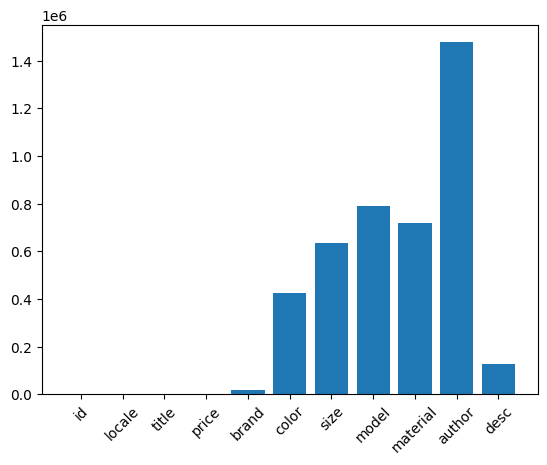

In [ ]:
nan_count = products.isna().sum()
plt.bar(nan_count.index,  nan_count.values)
plt.xticks(rotation=45)

In [ ]:
products['price'].describe()

count    1.551057e+06
mean     1.806107e+06
std      8.302930e+06
min      0.000000e+00
25%      1.119000e+01
50%      2.328000e+01
75%      7.990000e+02
max      4.000000e+07
Name: price, dtype: float64

In [ ]:
products.columns

{'whiskers': [<matplotlib.lines.Line2D at 0x7f819893b250>,
 'caps': [<matplotlib.lines.Line2D at 0x7f81f575df70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f81f575d9d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f81f57824f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f81f5782790>],
 'means': []}

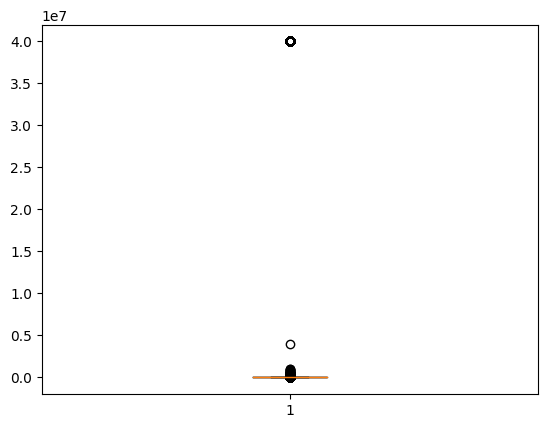

In [ ]:
plt.boxplot(products['price'])

(array([1481065.,       0.,       0.,       0.,   69992.]),
 array([       0.   ,  8000000.014, 16000000.028, 24000000.042,
        32000000.056, 40000000.07 ]),
 <BarContainer object of 5 artists>)

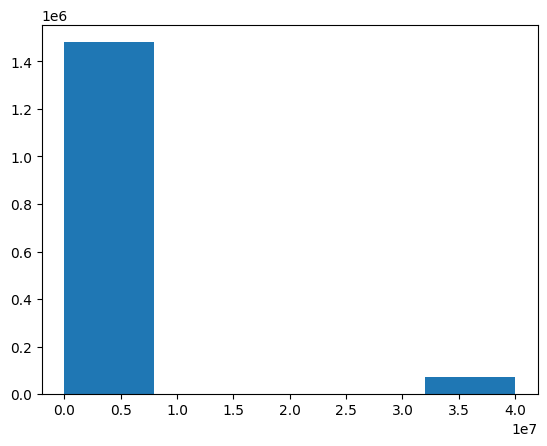

In [ ]:
plt.hist(products['price'], bins=5)

(array([1.452998e+06, 1.596200e+04, 4.956000e+03, 2.531000e+03,
        1.355000e+03, 8.090000e+02, 4.980000e+02, 3.500000e+02,
        2.360000e+02, 2.100000e+02]),
 array([     0.,  10000.,  20000.,  30000.,  40000.,  50000.,  60000.,
         70000.,  80000.,  90000., 100000.]),
 <BarContainer object of 10 artists>)

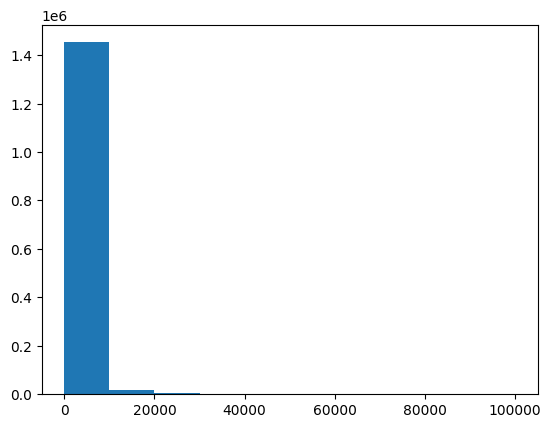

In [ ]:
plt.hist(products['price'].drop(products.index[products['price'] > 100000]))

In [ ]:
outlier_index = products.index[products['price'] > 100000]
products_without_outliers = products.drop(outlier_index)
products_without_outliers[products_without_outliers['price'] > 10000]

,id,locale,title,price,brand,color,size,model,material,author,desc
518365,B0BCF8G1Z1,JP,Dowinx ゲーミングチェア ファブリック オットマン付き オフィスチェア パソコンチェア...,24400.0,Dowinx,4Dアームレストのピンク,NaN,NaN,NaN,NaN,【ソファーの座り心地を再現】 ゲーミングチェアカテゴリの中、唯一高級ソファーに採用されている...
518385,B096RQXDWQ,JP,[ザノースフェイス] パンツ アルパインライトパンツ メンズ NB32210 撥水 ストレッ...,12938.0,THE NORTH FACE(ザノースフェイス),ブラック,S,NB32210,"92% ナイロン, 8% ポリウレタン",NaN,1年を通して山岳エリアでの行動を支えるパンツ
518398,B07VLPB1T9,JP,Creative Outdoor 折りたたみ式ワゴンカート カーゴ用 | 全地形 | ビーチ...,38216.0,Creative Outdoor Distributor,クールブルー,NaN,900179,合金鋼,NaN,NaN
518411,B0BDFBQ9CN,JP,リンナイ RC-U5801PE-WH [都市ガス ホワイト],51295.0,リンナイ,ホワイト,NaN,NaN,NaN,NaN,4951309364002
518438,B084MWGN9Z,JP,[アメリカンツーリスター] スーツケース キャリーケース アップライト スピナー 55/20...,19800.0,AmericanTourister,ブラック/グリーン2,One Size,132373,その他,NaN,TSAロック付き(ダイアル式)
...,...,...,...,...,...,...,...,...,...,...,...
913252,B09X34ZHRP,JP,ワインセラー コンプレッサー式 22本収納 Rintuf 70L ワインクーラー 4℃-16...,38800.0,"NINGBO HICON INTERNATIONAL INDUSTRY CO., LTD.",ブラック,70L,NaN,NaN,NaN,【4～16℃幅広い温度設定】理想的な湿度レベルを維持しながら、4~16℃の範囲で温度設定でき...
913283,B019ENUMBK,JP,サンワダイレクト キッチン椅子 キャスター/固定脚付 座面高さ54.5～67.5cm 360...,10800.0,サンワダイレクト,ホワイト,NaN,150-SNCH008W,NaN,NaN,キャスター使用時は軽い力でスイスイ移動することができ、キッチンでのちょっとした移動に最適です...
913303,B093C4GJCS,JP,Donner アコースティックギター 単板トップ 初心者セット 41インチ 上質な木材 アコ...,16980.0,Donner,琥珀色,JFボディ,NaN,NaN,NaN,【JFボディによる暖かい生音】DonnerギターはJFボディに加えて、カッタウェイデザインを...
913313,B09SG7LMD9,JP,Logicool G ハンコン G923 & 低遅延 ワイヤレス ゲーミングヘッドセット グ...,58800.0,Logicool G(ロジクール G),ブラック,NaN,G923,NaN,NaN,NaN


(array([1308260.,   95326.,   27958.,   13289.,    8165.,    4538.,
           3950.,    3123.,    2281.,    2070.]),
 array([    0. ,  1999.9,  3999.8,  5999.7,  7999.6,  9999.5, 11999.4,
        13999.3, 15999.2, 17999.1, 19999. ]),
 <BarContainer object of 10 artists>)

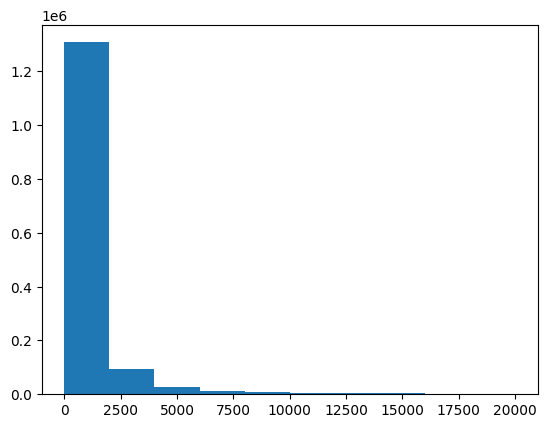

In [ ]:
plt.hist(products_without_outliers[products_without_outliers['price'] < 20000].price)

(array([379203.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  15806.]),
 array([       0.   ,  4000000.007,  8000000.014, 12000000.021,
        16000000.028, 20000000.035, 24000000.042, 28000000.049,
        32000000.056, 36000000.063, 40000000.07 ]),
 <BarContainer object of 10 artists>)

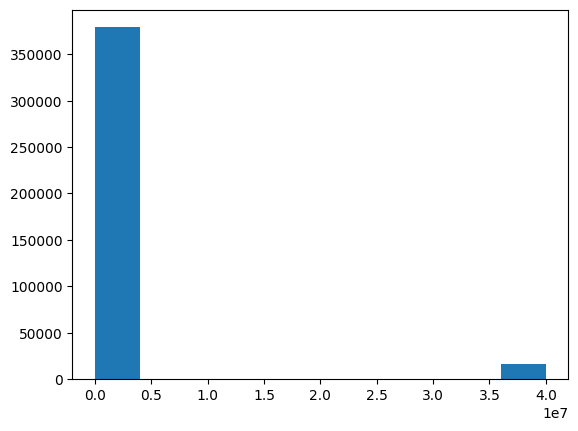

In [ ]:
plt.hist(products[products['locale'] == 'JP'].price)

In [ ]:
products[(products['locale'] == 'JP') & (products['price'] > 1000000)]

,id,locale,title,price,brand,color,size,model,material,author,desc
518393,B00A3PNT2S,JP,アール【すりガラス対応】 【日本製】 【結露対策】 すりガラス用結露吸水テープ トナカイ H...,40000000.07,アール,ホワイト,NaN,H-281,PET,NaN,サイズ:8*180*0.3㎝
518401,B07G2L16ZK,JP,[東京下町工房] 本革コインケース 小銭入れ 完全手作り 手縫い仕上げ コンパクト 使いやす...,40000000.07,東京下町工房,ブラック,Medium,0917,レザー,NaN,【完全手作り】 完全手作りで一つひとつ人の手により、丁寧に仕上げられています。シンプルで高級...
518443,B07SHBFG97,JP,N NEWKOIN 【最新強化版】 室内 HD テレビ アンテナ地デジアンテナ 卓上 TV ...,40000000.07,N NEWKOIN,Blue,SW003,NaN,NaN,NaN,【購入する前に読んでください】このアンテナを購入する前に、近くに信号塔があることを確認してく...
518451,B0B615DW5G,JP,イヌノカガヤキニチジョウヘン,40000000.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
518474,B0B9NG2KQ8,JP,ハロウィン 飾り付け 風船 バルーン 装飾セット パーティー イベント HAPPY HALL...,40000000.07,Xinvery,B set,NaN,X0002,紙吹雪,NaN,【 楽しく飾りつけ】初心者＆自信がない方でもスムーズにご準備できます。素敵なガーランドが作り...
...,...,...,...,...,...,...,...,...,...,...,...
913248,B00D0X3KH4,JP,【正規品】 Herman Miller (ハーマンミラー) セイルチェア オフィスチェア グ...,40000000.07,HermanMiller(ハーマンミラー),グレー,巾73x奥行73ｘ高さ89~99,AS1YA23HA N2 65 BB SG SG 7314,アルミニウム,NaN,「設置・組立・引き取り」サービスを一部地域でご利用いただけます。本ページ内に「サービスオプシ...
913274,B0B2RMRNFH,JP,くらしモアさぬき丸一製麺 本場熟成さぬきうどん 5食入,40000000.07,くらしモアさぬき丸一製麺,NaN,NaN,NaN,NaN,NaN,冷凍
913289,B07Y8HG5F7,JP,CINECE ハロウィン 飾り コウモリ ステッカー 108枚セット PVC製 立体 取り外...,40000000.07,CINECE,NaN,NaN,NaN,ポリ塩化ビニル,NaN,付属の両面シールを胴体部分に貼って壁に貼り付ける仕様になります。
913299,B0BCWJK33Y,JP,フック 壁 傷つけない 耐荷重5kg (3個入り) 石膏ボード 壁紙 賃貸 ホチキスで取付 ...,40000000.07,ウエルスジャパン(Wealth JAPAN),ホワイト,‎縦5.2×横3×厚さ2cm,NaN,NaN,NaN,壁面の有効利用で・お部屋がスッキリ!


(array([3.5089e+05, 1.6128e+04, 4.9940e+03, 2.5470e+03, 1.3710e+03,
        8.0600e+02, 5.0800e+02, 3.5000e+02, 2.3700e+02, 2.0800e+02]),
 array([    0. ,  9997.6, 19995.2, 29992.8, 39990.4, 49988. , 59985.6,
        69983.2, 79980.8, 89978.4, 99976. ]),
 <BarContainer object of 10 artists>)

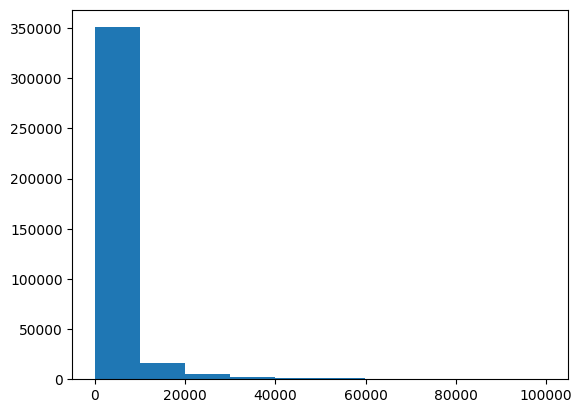

In [ ]:
plt.hist(products[(products['locale'] == 'JP') & (products['price'] < 100000)].price)

In [ ]:
products[(products['locale'] == 'DE') & (products['price'] > 1000000)]

,id,locale,title,price,brand,color,size,model,material,author,desc
32,B01MREMJ90,DE,The New York Doll Collection 11 Zoll /28cm Afr...,40000000.07,The New York Doll Collection,African American,NaN,B121,Vinyl,NaN,"11 Zoll/28cm Größe, die für kleine Kinder leic..."
35,B00IK6I6YS,DE,Donnie Darko [dt./OV],40000000.07,NaN,NaN,NaN,NaN,NaN,Drew Barrymore,NaN
54,B0B59DRXBT,DE,"GOYJOY Hundekäfig für Auto, groß, tragbar, fal...",40000000.07,GOYJOY,Gelb,S,NaN,Eisen,NaN,"Atmungsaktiv, belüftet auf allen Seiten, wird ..."
58,B07QCQK6CV,DE,Der mit dem Wolf tanzt,40000000.07,NaN,NaN,NaN,NaN,NaN,Floyd „Red Crow“ Westerman,NaN
70,B08BPH1WMD,DE,SET MIT 6 STÜCK einfachen Aufbewahrungsboxen a...,40000000.07,KANGURU,Grau,29x51x20cm,616 AZ,Karton,NaN,100% HERGESTELLT IN ITALIEN
...,...,...,...,...,...,...,...,...,...,...,...
518281,B08DTVRHB6,DE,Kostümplanet® Hexenkostüm Kinder mit Hut Mädch...,40000000.07,Kostümplanet,Rosa-pink,116,NaN,100% Polyester,NaN,✅ Komplettes Kinderkostüm inklusive Hut
518285,B0BGHTCLY2,DE,GREENSKY 912 XL Druckerpatronen Set Kompatibel...,40000000.07,GREENSKY,"Schwarz, Cyan, Magenta, Gelb",NaN,912 912XL multipack,NaN,NaN,912 XL Multipack Patronen Kompatibel für HP Of...
518316,B07TNTJXVC,DE,"PremiumCord DVI-VGA Verbindungskabel - 2m, DVI...",40000000.07,KRUP s.r.o.,NaN,2 m,kpdvi1a2,NaN,NaN,Anschlüsse: VGA 15-Stecker / DVI-I-Stecker
518319,B09JM3D9TW,DE,PLIMA fix für schmale Glasleisten - Universal ...,40000000.07,PLIMA,Weiß,NaN,NaN,Kunststoff,NaN,! PVC-Glasleistentiefe bis zur Dichtung 4-12 m...


(array([4.82566e+05, 6.80400e+03, 2.21000e+03, 1.08500e+03, 7.36000e+02,
        3.60000e+02, 2.45000e+02, 2.00000e+02, 1.29000e+02, 1.21000e+02]),
 array([   0.   ,  199.999,  399.998,  599.997,  799.996,  999.995,
        1199.994, 1399.993, 1599.992, 1799.991, 1999.99 ]),
 <BarContainer object of 10 artists>)

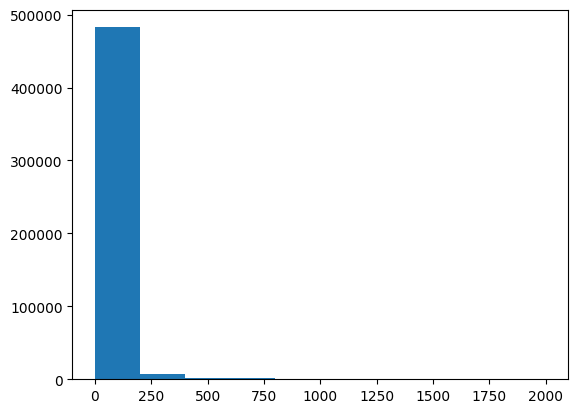

In [ ]:
plt.hist(products[(products['locale'] == 'DE') & (products['price'] < 2000)].price)

In [ ]:
products[(products['locale'] == 'UK') & (products['price'] > 1000000)]

,id,locale,title,price,brand,color,size,model,material,author,desc
913359,B01AS7VCY2,UK,Greek Style EasiYo Yogurt 8 Sachet Pack | Each...,40000000.07,EasiYo,NaN,NaN,NaN,NaN,NaN,3 EASY STEPS - Add the contents of your chosen...
913360,B08BR59PCZ,UK,"ROCKBROS Bike Mudguards Set, Adjustable 2 Part...",40000000.07,ROCKBROS,Black,One Size,NaN,NaN,NaN,🚴‍♂️DURABLE & ADJUSTABLE: High quality bicycle...
913365,B09R526SLM,UK,Kena: Bridge of Spirits - Deluxe Edition (PS4/...,40000000.07,Maximum Games,NaN,NaN,KBS-PS4-EU,NaN,NaN,Build Your Team: Find and collect Rot to gain ...
913408,B0B88CRKCX,UK,ADMOS 50 Citronella Incense Sticks With Wooden...,40000000.07,ADMOS,Brown,M,AD-128,NaN,NaN,ADMOS Brand Citronella Incense Sticks with woo...
913410,B078SV63KN,UK,"Morrisons Sweetcorn in Water, 326g",40000000.07,Morrisons,NaN,NaN,109381100,NaN,NaN,A 1/2 can serving contains 1 portion of your 5...
...,...,...,...,...,...,...,...,...,...,...,...
1413384,B07VD72BMH,UK,Outus 30 Pieces Foam Halloween Pumpkins Foam P...,40000000.07,Outus,NaN,NaN,NaN,Foam,NaN,DIY crafts: these blank foam pumpkin can be dr...
1413408,B09BW3C3K7,UK,Marriner Get Cosy Super Chunky Yarn with 100% ...,40000000.07,Marriner,Cream,5 Ball Pack,NaN,Polyester,NaN,A luxuriously soft yarn that could not be more...
1413416,B0BD3ZLRJK,UK,Hanging Halloween Decorations Single Pre-Insta...,40000000.07,YAAVAAW,Orange,L,YA-Hanging,Polyester,NaN,Design:A unique design that combines the grima...
1413448,B09B4B58NS,UK,"Padded Envelopes A3 A4 A5 A6, Padded Bubble En...",40000000.07,Merrimen,100pk Gold,A4,NaN,NaN,NaN,Easy to use with excellent label adhesion. Wri...


In [ ]:
products[(products['locale'] == 'UK')].head()

,id,locale,title,price,brand,color,size,model,material,author,desc
913336,B087LZNPHS,UK,"SOCHOW Sherpa Fleece Throw Blanket, Double-Sid...",24.99,SOCHOW,Teal Green,127cm×150cm,NaN,100% Polyester,NaN,COLOR: The sherpa throw blanket is available i...
913337,B08THFN1KX,UK,Hippowarehouse Personalised Photo Printed Mous...,9.95,Hippowarehouse,White,240mm x 190mm x 60mm,50245-Mat-Perso,Rubber,NaN,Competitively priced
913338,0804185328,UK,"500 Easy Recipes for Every Machine, Both Stove...",16.49,Clarkson Potter,White,NaN,NaN,NaN,"Scarbrough, Mark",NaN
913339,B09VBKDBW6,UK,"TYHJOY Mini Bag Sealer, Handheld Vacuum Heat S...",11.99,TYHJOY,Black,NaN,FBA-sealer-black,Acrylonitrile Butadiene Styrene,NaN,【AFTER-SALE】This handheld food heat sealer sho...
913340,B096ZW8B49,UK,Lucosobie Steering Wheel Lock - Car Anti-Theft...,26.99,Lucosobie,Black,NaN,NaN,Alloy Steel,NaN,🔐【 Anti-Friction & Customer First】Each box of ...


(array([4.69781e+05, 3.37300e+03, 7.93000e+02, 3.79000e+02, 2.35000e+02,
        1.11000e+02, 8.30000e+01, 5.30000e+01, 3.20000e+01, 1.30000e+01]),
 array([   0.   ,  199.999,  399.998,  599.997,  799.996,  999.995,
        1199.994, 1399.993, 1599.992, 1799.991, 1999.99 ]),
 <BarContainer object of 10 artists>)

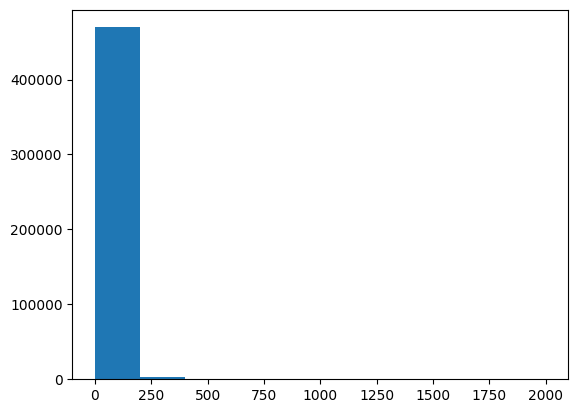

In [ ]:
plt.hist(products[(products['locale'] == 'UK') & (products['price'] < 2000)].price)

In [ ]:
uk_product_sample = products[(products['locale'] == 'UK') & (products['price'] < 100000)].sample(100)
uk_product_sample

,id,locale,title,price,brand,color,size,model,material,author,desc
1059581,184990149X,UK,My Kitchen Table: 100 Cakes and Bakes (My Kitc...,4.49,BBC Books,NaN,NaN,NaN,NaN,"Berry, Mary",NaN
1150238,B08Q15C2FB,UK,TRESemme Rich Moisture all-day hydration with ...,5.00,TRESEMME,WHITE,900 ml (Pack of 1),TRE247,NaN,NaN,After shampooing with Tresemme Rich Moisture S...
1399991,B09YHDLT2J,UK,"2023 Diary A5 Week to View, Weekly & Monthly P...",11.99,ZXHQ,NaN,Flowers & Birds 2023,ZXNLB2023ZLA0005,NaN,NaN,2023 Weekly & Monthly Diary: Week to view page...
1064355,B0BCP5PJQN,UK,"LANDOT 6Pcs Nail Art Brushes Set, Nail Design ...",7.99,LANDOTPRO,Nail Pen Brushes,NaN,NaN,NaN,NaN,"💖【CONVENIENT DESIGN】Brush pen Macaron color, b..."
1011424,B01FULV4LW,UK,Veewon Silicone Pot Holder Oven Mini Mitt Cook...,6.99,Veewon,Red,NaN,NaN,PVC,NaN,Heat resistant pvc plastic gloves.Great additi...
...,...,...,...,...,...,...,...,...,...,...,...
927410,B09DXVS518,UK,"12 Pack Fruit Fly Traps, Double-sided Sticky F...",2.99,lohey,12 PACK,NaN,NaN,Paper,NaN,Comfortable Appearance & Easy to setup: Butter...
1378819,B09ZL4KS52,UK,JINYUDOME Blue Dusters Refills for Cleaning Di...,16.99,Hangzhou jigeji,Blue1,1,20,NaN,NaN,"Dusting furniture, knick-knacks, bookshelves, ..."
1176606,B07PTRHJWH,UK,Alphabet barn 1st Anniversary Plaque Wooden Gi...,5.99,Alphabet Barn,Gold,1 year,NaN,Wood,NaN,1st WEDDING ANNIVERSARY or PAPER ANNIVERSARY –...
1335892,B07TL9WJWX,UK,Ridge XT200 Pro Spin 360 Freestyle Stunt Scoot...,99.99,Ridge Scooters,Full Neochrome,NaN,XT200-101-FULLNEO,Aluminium,NaN,ABEC 7 Bearings / Rider Max Weight 100kg


In [ ]:
tfidf_vectorizer = TfidfVectorizer()

In [ ]:
uk_product_titles = uk_product_sample.title

In [ ]:
tfidf_matrix = tfidf_vectorizer.fit_transform(uk_product_titles)

In [ ]:
similarity_matrix = cosine_similarity(tfidf_matrix)

In [ ]:
similarity_matrix

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.10489951],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.05445574],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.10489951, 0.        , ..., 0.05445574, 0.        ,
        1.        ]])

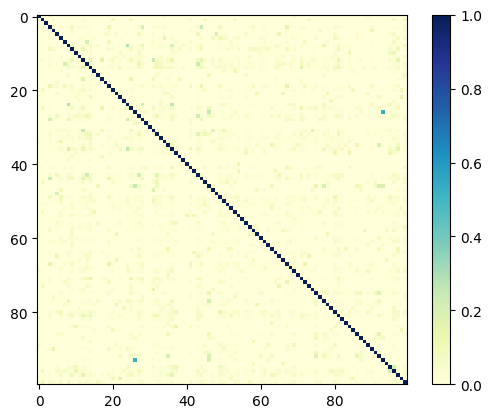

In [ ]:
plt.imshow(similarity_matrix, cmap='YlGnBu')
plt.colorbar()
plt.show()

## Train and Test Sessions

In [ ]:
train_sessions = read_train_data()
train_sessions.sample(5)

,prev_items,next_item,locale
3116859,['B0925RQM9T' 'B0925T7MWM' 'B0925RLH8T' 'B08MV...,B08MVRDFF2,UK
1838298,['B0B9W5SFX4' 'B0978RWNXM'],B000WMIQ48,JP
1098977,['B07WKN8NQQ' 'B074XFMCXZ'],B00M49PJ1U,DE
1415395,['B00LTKUNJS' 'B00LTKUK28'],B07KR61KM2,JP
485655,['B08KRYTY5P' 'B00OKPGK4G'],B07KMF1N39,DE


In [ ]:
train_sessions.head(5)

,prev_items,next_item,locale
0,['B09W9FND7K' 'B09JSPLN1M'],B09M7GY217,DE
1,['B076THCGSG' 'B007MO8IME' 'B08MF65MLV' 'B001B...,B001B4THSA,DE
2,['B0B1LGXWDS' 'B00AZYORS2' 'B0B1LGXWDS' 'B00AZ...,B0767DTG2Q,DE
3,['B09XMTWDVT' 'B0B4MZZ8MB' 'B0B7HZ2GWX' 'B09XM...,B0B4R9NN4B,DE
4,['B09Y5CSL3T' 'B09Y5DPTXN' 'B09FKD61R8'],B0BGVBKWGZ,DE


In [ ]:
train_sessions['prev_items'].str.strip("[']").str.replace("\n", "").str.split("' '")

0                                   [B09W9FND7K, B09JSPLN1M]
1           [B076THCGSG, B007MO8IME, B08MF65MLV, B001B4TKA0]
2          [B0B1LGXWDS, B00AZYORS2, B0B1LGXWDS, B00AZYORS...
3          [B09XMTWDVT, B0B4MZZ8MB, B0B7HZ2GWX, B09XMTWDV...
4                       [B09Y5CSL3T, B09Y5DPTXN, B09FKD61R8]
                                 ...                        
3606244                 [B086CYFSKW, B0874F9859, B086CYFSKW]
3606245                             [B09NRZKZ7V, B08WJTPV93]
3606246                             [B085JFX7MP, B085JGHW8R]
3606247                             [B00B0UING2, B00B0UING2]
3606248     [B092S9D1SD, B09XQQ1S72, B0852MS7QC, B0B1V43MN1]
Name: prev_items, Length: 3606249, dtype: object

In [ ]:
train_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3606249 entries, 0 to 3606248
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   prev_items  object
 1   next_item   object
 2   locale      object
dtypes: object(3)
memory usage: 82.5+ MB


In [ ]:
def string2list(list_):
  list_ = list_.replace(' ', ',') 
  list_ = list_.replace('\'', '"')
  list_ = list_.replace('\n', '')
  list_ = list_.replace('\r', '')

  return list_

In [ ]:
train_sessions['prev_items'] = train_sessions['prev_items'].apply(string2list).apply(lambda sess: len(sess))

In [ ]:
train_sessions['prev_items']

0           27
1           53
2          118
3           92
4           40
          ... 
3606244     40
3606245     27
3606246     27
3606247     27
3606248     53
Name: prev_items, Length: 3606249, dtype: int64

In [ ]:
train_sessions['prev_items'].value_counts()

27      1349564
40       746720
53       462070
66       296836
79       200392
         ...   
1327          1
1132          1
1548          1
1678          1
2614          1
Name: prev_items, Length: 134, dtype: int64

In [ ]:
train_sessions['prev_items'].apply(lambda x: len(x))

0           27
1           53
2          119
3           93
4           40
          ... 
3606244     40
3606245     27
3606246     27
3606247     27
3606248     53
Name: prev_items, Length: 3606249, dtype: int64

In [ ]:
prev_items_expanded = train_sessions['prev_items'].apply(pd.Series)

In [ ]:
prev_items_expanded

In [ ]:
train_sessions_de = train_sessions.loc[train_sessions['locale'] == 'DE']
train_sessions_uk = train_sessions.loc[train_sessions['locale'] == 'UK']
train_sessions_jp = train_sessions.loc[train_sessions['locale'] == 'JP']

In [ ]:
train_sessions_de

In [ ]:
test_sessions = read_test_data(task)
test_sessions.sample(5)

,prev_items,locale
3553,['B01IBL6MPQ' 'B00M35Y2MC' 'B01IBL6MPQ' 'B01LY...,DE
206329,['B07KYPW8RS' 'B07KYNWX7X'],UK
234067,['B0B1LKLC18' 'B09WXZYN7C' 'B0875CTMGH' 'B07Z9...,UK
188509,['B09ZPH4TPR' 'B09ZPHB6GG' 'B087JSP6ZZ' 'B07MF...,JP
18027,['B00GUYHCME' 'B09L1D6BSC'],DE


# Preprocessing and Prediction

### Note 

Approach and methods used in the following are drawn from the following articel:
https://www.pinecone.io/learn/faiss-tutorial/

Function for dimensionality reduction used: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

In [ ]:
!apt install libomp-dev
!pip install faiss-gpu # if you don't have a NVIDA GPU use pip install faiss


Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (1:10.0-50~exp1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import faiss

In [ ]:
products['title'].head(5)

0    RED DRAGON Amberjack 3 - Steel Tip 22 Gramm Wo...
1    Simply Keto Lower Carb* Schokodrops ohne Zucke...
2    Sennheiser 508377 PC 5.2 Chat, Stilvolles Mult...
3    AmyBenton Auto ab 1 2 3 ahre - Baby Aufziehbar...
4        PLAYMOBIL - 70522 - Cavaliere mit grauem Pony
Name: title, dtype: object

In [ ]:
products = products[~products['locale'].isin(['ES', 'FR', 'IT'])].loc[:, ['id', 'locale', 'title']]

In [ ]:
products_de = products[products['locale'] == 'DE']

In [ ]:
products_de.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 518327 entries, 0 to 518326
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      518327 non-null  object
 1   locale  518327 non-null  object
 2   title   518327 non-null  object
dtypes: object(3)
memory usage: 15.8+ MB


In [ ]:
tfidf_vectorizer = TfidfVectorizer()

In [ ]:
title_vectors_de = tfidf_vectorizer.fit_transform(products_de['title'].fillna(''))

In [ ]:
!nvidia-smi


Mon Apr 24 18:05:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
title_vectors_de.shape

(518327, 326988)

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
svd = TruncatedSVD(n_components=100)
tfidf_reduced = svd.fit_transform(title_vectors_de)

In [ ]:
dim = tfidf_reduced.shape[1]

In [ ]:
# get possible no. of centroids in final vector
for n in range(1, 101):
  modulo = dim % n
  if modulo == 0:
    print(n)

1
2
4
5
10
20
25
50
100


In [ ]:
dim

100

In [ ]:
nlist = 100 # number of voronoi cells, i.e. partitions of vectors in a search space
m = 20 # number of centroids in the final vector, d must be a multiple of m - see for loop in previous cell
bits = 8 # some parameter which may need to be adjusted depending on the other parameters for it to work (however don't quite understand what it actually does) - 8 bits seems to be fine
quantizer = faiss.IndexFlatL2(dim) # intermediate step needed to later get back the "real" index of a vector, while searching the index

In [ ]:
# the chosen index needs to be trained as it clusters sub-splits of vectors
# training the index on the whole tfidf-vector-matrix is not feasable, we need to sample and train on a sample
num_samples = 10000
sample_indices = np.random.choice(tfidf_reduced.shape[0], num_samples, replace=False)
sample_vectors = tfidf_reduced[sample_indices]

In [ ]:
sample_vectors.shape[1]

100

In [ ]:
index_cpu = faiss.IndexIVFPQ(quantizer, dim, nlist, m, bits)
index_gpu = faiss.index_cpu_to_gpu(faiss.StandardGpuResources(), 0, index_cpu) # not needed for cpu only

In [ ]:
index_gpu.is_trained

False

In [ ]:
# train index
index_gpu.train(sample_vectors.astype('float32'))

In [ ]:
index_gpu.is_trained

True

In [ ]:
index_gpu.add(tfidf_reduced.astype('float32')) # add vectors to the index

In [ ]:
search_query = ["PLAYMOBIL - 70522 - Cavaliere mit grauem Pony"] # input for our prediction
xq = tfidf_vectorizer.transform(search_query) # transform to shape needed
xq_transformed = svd.transform(xq).astype('float32') # transform to shape needed
k = 100 # number of nearest neighbours to be searched in the index

In [ ]:
xq.shape

(1, 326988)

In [ ]:
D, I = index_gpu.search(xq_transformed, k) # search index with a search query xq

In [ ]:
print(I)

[[     4 490480 120306 488475 243448  85545 433488 269577 147701 294046
   87867 438126 453478 107823 355422 358185 185062 211151  44500 504294
  314623 482606  89068 391820 456366 263204 340205 263996  50147 351725
  505678 282086 266150   8321 301704 382171 287861  92411 358042 227101
  236209 304482 369682 335797 132502 191289 370701 368756  53513  62500
  336146  51081  76389 150096  84726 497387 475182 220597 486071 195138
   50244 344001 450647 434939 490520 138078 517385 271146  98895 413056
  461797 334218  57538 435610   1839 358365  94439 517384 388329 252357
  103351 345594  34556 119635 329026 152676 280982 298286 417074  61746
   11564   6016 247297 404635 308611  29463 451348 219432 351895 506064]]


In [ ]:
[f"{i}: {products_de.loc[i]['title']}" for i in I[0]]

['4: PLAYMOBIL - 70522 - Cavaliere mit grauem Pony',
 '490480: PLAYMOBIL - 70521 - Cavaliere mit beigem Pony',
 '120306: Schleich 41431 - Pferdepflegerin mit Island Pony Stute',
 '488475: PLAYMOBIL 1.2.3 - 70402 - Fee mit Kitz',
 '243448: PLAYMOBIL 70098 - Meerjungfrau mit Meeresschnecke',
 '85545: PLAYMOBIL 70060 - Reiter mit Pony',
 '433488: Playmobil 6879 - Ganoven-Quad mit Seilwinde',
 '269577: Playmobil 5187 - Polizei-Truck mit Speedboot',
 '147701: Playmobil 6657 - Kinderklinik mit Einrichtung',
 '294046: PLAYMOBIL® 70987 Poolparty mit Rutsche',
 '87867: PLAYMOBIL® 70609 Aqua Park mit Rutschen',
 '438126: PLAYMOBIL Summer Fun 6669 Aquapark mit Rutschentower',
 '453478: PLAYMOBIL - 70709 - SCOOBY-DOO mit dunklem Ritter',
 '107823: Play-Doh Kitchen Creations Pizzabäckerei Spielset mit 6 Dosen 8 Accessoires',
 '355422: PLAYMOBIL® 70744 Speedboot mit Unterwassermotor',
 '358185: PLAYMOBIL - 70820 - Stuntshow-Starterpaket mit Rampe',
 '185062: Playmobil 5176 - Polizei-Kommandostation 

# TO-DO

1. Function: Searches for the title of products in a session of a user and processes it as an input for the search in the index
2. Function: Creates the ANN index for a locale
3. Function: Predicts the next 100 items for each session in a locale

## Generate Submission 🏋️‍♀️



Submission format:
1. The submission should be a **parquet** file with the sessions from all the locales. 
2. Predicted products ids per locale should only be a valid product id of that locale. 
3. Predictions should be added in new column named **"next_item_prediction"**.
4. Predictions should be a list of string id values

In [ ]:
def random_predicitons(locale, sess_test_locale):
    random_state = np.random.RandomState(42)
    products = read_product_data().query(f'locale == "{locale}"')
    predictions = []
    for _ in range(len(sess_test_locale)):
        predictions.append(
            list(products['id'].sample(PREDS_PER_SESSION, replace=True, random_state=random_state))
        ) 
    sess_test_locale['next_item_prediction'] = predictions
    sess_test_locale.drop('prev_items', inplace=True, axis=1)
    return sess_test_locale

In [ ]:
test_sessions = read_test_data(task)
predictions = []
test_locale_names = test_sessions['locale'].unique()
for locale in test_locale_names:
    sess_test_locale = test_sessions.query(f'locale == "{locale}"').copy()
    predictions.append(
        random_predicitons(locale, sess_test_locale)
    )
predictions = pd.concat(predictions).reset_index(drop=True)
predictions.sample(5)

,locale,next_item_prediction
197622,JP,"[B0B3JKGTBH, B07WFD1L1R, B0B1N2FMMG, B0BLJSMWJ..."
108611,JP,"[B07WV5GXPB, B0B7DS3HQL, B0866HDFTS, B009GQYDX..."
284074,UK,"[B09BB5SPR3, B0816CXMSZ, B08JV76967, B08MW68KC..."
34652,DE,"[B007H6POYW, B08M5GZGFT, B08JQZMFL7, B0BKP9BSL..."
268639,UK,"[B06XCGCKG7, B0B9NXKN54, B091YX63K7, B00Z65X1G..."


# Validate predictions ✅

In [ ]:
def check_predictions(predictions, check_products=False):
    """
    These tests need to pass as they will also be applied on the evaluator
    """
    test_locale_names = test_sessions['locale'].unique()
    for locale in test_locale_names:
        sess_test = test_sessions.query(f'locale == "{locale}"')
        preds_locale =  predictions[predictions['locale'] == sess_test['locale'].iloc[0]]
        assert sorted(preds_locale.index.values) == sorted(sess_test.index.values), f"Session ids of {locale} doesn't match"

        if check_products:
            # This check is not done on the evaluator
            # but you can run it to verify there is no mixing of products between locales
            # Since the ground truth next item will always belong to the same locale
            # Warning - This can be slow to run
            products = read_product_data().query(f'locale == "{locale}"')
            predicted_products = np.unique( np.array(list(preds_locale["next_item_prediction"].values)) )
            assert np.all( np.isin(predicted_products, products['id']) ), f"Invalid products in {locale} predictions"

In [ ]:
check_predictions(predictions)

In [ ]:
# Its important that the parquet file you submit is saved with pyarrow backend
predictions.to_parquet(f'submission_{task}.parquet', engine='pyarrow')

## Submit to AIcrowd 🚀

In [ ]:
# You can submit with aicrowd-cli, or upload manually on the challenge page.
!aicrowd submission create -c task-1-next-product-recommendation -f "submission_task1.parquet"